In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import operator

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from lib.unpack import unpack_drawings
from lib.strokes import transform_strokes, inverse_transform_strokes, get_n_points
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import get_means_stds, standarize_data, unstandarize_flat_strokes
from lib.plot import get_canvas, plot, get_animation
from lib.model import Decoder
from lib.model import evaluate, train

# Load and show dataset

In [4]:
dataset = unpack_drawings('./data/The Eiffel Tower.bin')
dataset = unpack_drawings('./data/cat.bin')
dataset = list(dataset)

In [5]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

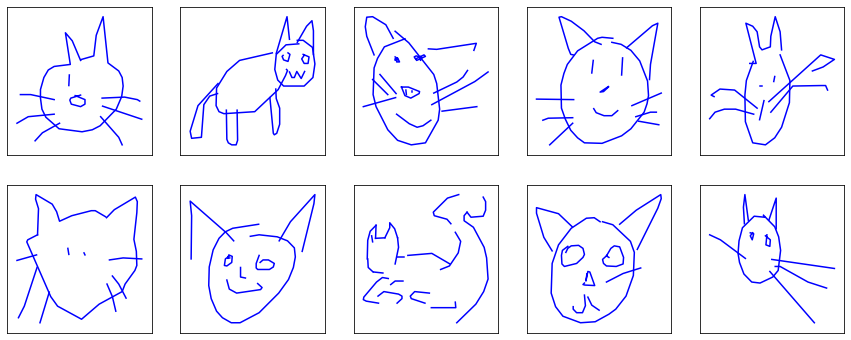

In [55]:
fig, axarr = get_canvas(2, 5)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

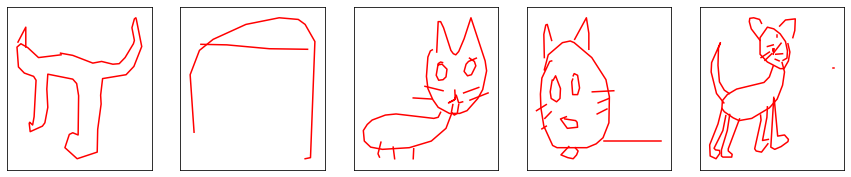

In [56]:
fig, axarr = get_canvas(1, 5)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [8]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [9]:
HTML(anim.to_html5_video())

Text(0.5, 1.0, 'delta_y')

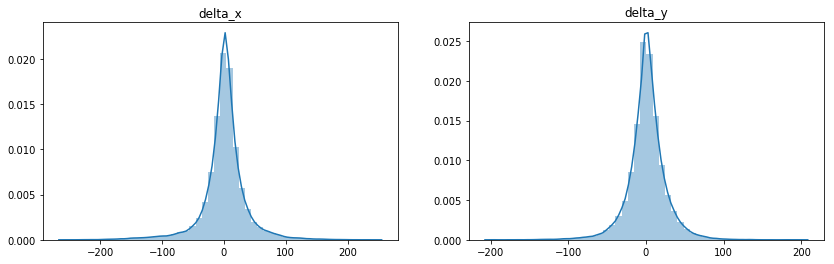

In [10]:
# Transformed stroke coordinates follow a gaussian distribution.

transformed_drawings = [transform_strokes(good_drawings[i]) for i in range(1000)]

delta_xs, delta_ys = [], []
for transformed_drawing in transformed_drawings:
    delta_xs += list(map(operator.itemgetter(0), transformed_drawing))
    delta_ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(delta_xs, ax=axs[0]).set_title('delta_x')
sns.distplot(delta_ys, ax=axs[1]).set_title('delta_y')

# Create pytorch dataset

In [11]:
drawings = [drawing for drawing in good_drawings if get_n_points(drawing) > 2]
transformed_drawings = [transform_strokes(drawing) for drawing in drawings]

In [12]:
#idxs = list(range(1))
#transformed_drawings = [transformed_drawings[i] for i in idxs]

In [13]:
ds = get_dataset(transformed_drawings)

In [14]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=0.00006)
#train_idxs, val_idxs = [idxs, idxs]

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(2, 1)

In [15]:
train_means_stds = get_means_stds(train_ds)
val_means_stds = get_means_stds(val_ds)

In [16]:
# Debug
train_batches = get_batches(train_ds, train_means_stds, batch_size=2)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

print(data_batch.shape, labels_batch.shape, lengths_batch.shape)
print()
print()

for tensor in (data_batch, labels_batch, lengths_batch):
    print(tensor)
    print()

torch.Size([173, 2, 5]) torch.Size([173, 2, 5]) torch.Size([2])


tensor([[[ 1.2901, -1.6757,  1.0000,  0.0000,  0.0000],
         [ 0.3532, -0.0603,  1.0000,  0.0000,  0.0000]],

        [[ 1.6454, -0.8898,  1.0000,  0.0000,  0.0000],
         [ 1.5808, -1.0645,  1.0000,  0.0000,  0.0000]],

        [[ 0.7086, -0.1040,  1.0000,  0.0000,  0.0000],
         [ 0.6117, -0.1913,  1.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])

tensor([[[ 1.6454, -0.8898,  1.0000,  0.0000,  0.0000],
         [ 1.5808, -1.0645,  1.0000,  0.0000,  0.0000]],

        [[ 0.7086, -0.1040,  1.0000,  0.0000,  0.0000],
         [ 0.6117, -0.1913,  1.0000,  0.0000,  0.0000]],

       

In [17]:
K = 4
model = Decoder(n_hidden=5, K=K)

if torch.cuda.is_available():
    model = model.cuda()

train_batches = get_batches(train_ds, train_means_stds, batch_size=1024)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

gmm_params, state_params, (hidden_state, cell_state) = model(data_batch, lengths_batch)
pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = gmm_params

In [18]:
print(pi.shape)
print(mu_x.shape, mu_y.shape)
print(sigma_x.shape, sigma_y.shape, rho_xy.shape)
print(state_params.shape)
print(hidden_state.shape, cell_state.shape)

torch.Size([90, 2, 4])
torch.Size([90, 2, 4]) torch.Size([90, 2, 4])
torch.Size([90, 2, 4]) torch.Size([90, 2, 4]) torch.Size([90, 2, 4])
torch.Size([90, 2, 3])
torch.Size([1, 2, 5]) torch.Size([1, 2, 5])


In [19]:
def bivariate_normal_pdf(x, y, mu_x, mu_y, sigma_x, sigma_y, rho_xy):
    
    z_x = ((x - mu_x) / sigma_x) ** 2
    z_y = ((y - mu_y) / sigma_y) ** 2
    z_xy = (x - mu_x) * (y - mu_y) / (sigma_x * sigma_y)
    z = z_x + z_y - 2 * rho_xy * z_xy
    exp = torch.exp(-z / (2 * (1 - rho_xy ** 2)))
    norm = 2 * np.pi * sigma_x * sigma_y * torch.sqrt(1 - rho_xy ** 2)
    
    return exp / norm

In [20]:
max_length = lengths_batch.max()
points = labels_batch[:max_length, :, :2]
points_x, points_y = points.split(1, dim=-1)
points_x = points_x.repeat(1, 1, K)
points_y = points_y.repeat(1, 1, K)

In [21]:
bivariate_normal_pdf(points_x, points_y, *gmm_params[1:]).shape

torch.Size([90, 2, 4])

In [22]:
from torch.distributions.multivariate_normal import MultivariateNormal

def reconstruction_loss(gmm_params, state_params, labels_batch, lengths_batch):

    pi = gmm_params[0]
    K = pi.shape[2]
    
    max_length = lengths_batch.max()
    batch_size = labels_batch.shape[1]
    mask = torch.zeros(max_length, batch_size)
    for i, length in enumerate(lengths_batch):
        mask[:length, i] = 1

    points = labels_batch[:max_length, :, :2]
    points_x, points_y = points.split(1, dim=-1)
    points_x = points_x.repeat(1, 1, K)
    points_y = points_y.repeat(1, 1, K)
    gaussian_probs = bivariate_normal_pdf(points_x, points_y, *gmm_params[1:])

    gmm_probas = (gaussian_probs * pi).sum(dim=-1) + 1e-5
    points_loss = -gmm_probas[mask == 1].log().mean()

    stroke_states = labels_batch[:max_length, :, 2:]
    states_losses = (stroke_states * state_params.log()).sum(dim=-1)
    states_loss = -states_losses[mask == 1].mean()

    return points_loss + states_loss

In [23]:
reconstruction_loss(gmm_params, state_params, labels_batch, lengths_batch)

tensor(3.8326, grad_fn=<AddBackward0>)

In [24]:
def bivariate_normal_distribution(mu_x, mu_y, sigma_x, sigma_y, rho_xy):

    mu_x = mu_x.unsqueeze(-1)
    mu_y = mu_y.unsqueeze(-1)
    sigma_x = sigma_x.unsqueeze(-1)
    sigma_y = sigma_y.unsqueeze(-1)
    rho_xy = rho_xy.unsqueeze(-1)

    mu = torch.cat([mu_x, mu_y], dim=-1)

    sigma_xy = sigma_x * sigma_y
    upper_row_cov = torch.cat([sigma_x ** 2, rho_xy * sigma_xy], dim=-1).unsqueeze(-2)
    lower_row_cov = torch.cat([rho_xy * sigma_xy, sigma_y ** 2], dim=-1).unsqueeze(-2)
    cov = torch.cat([upper_row_cov, lower_row_cov], dim=-2)

    return MultivariateNormal(mu, cov)

In [25]:
last_gmm_params = [param[-1] for param in gmm_params][1:]
bivariate_normal_distribution(*last_gmm_params).sample().shape

torch.Size([2, 4, 2])

In [26]:
from torch.distributions.multinomial import Multinomial

def sample(gmm_params, state_params):

    pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = gmm_params
    
    gaussians = bivariate_normal_distribution(mu_x, mu_y, sigma_x, sigma_y, rho_xy)
    pi = pi.unsqueeze(dim=-1).repeat(1, 1, 2)
    gmm_preds = (pi * gaussians.sample()).sum(dim=-2)

    state_preds = Multinomial(1, state_params[-1]).sample()

    preds = torch.cat([gmm_preds, state_preds], dim=1)
    
    return preds

In [27]:
last_gmm_params = [param[-1] for param in gmm_params]
sample(last_gmm_params, state_params)

tensor([[-0.0570,  0.1168,  0.0000,  0.0000,  1.0000],
        [ 0.4014, -0.4192,  0.0000,  0.0000,  1.0000]], grad_fn=<CatBackward>)

In [34]:
def extract_start_of_stroke(ds, n_points=1):
    idx = np.random.choice(len(ds))
    flat_strokes = ds[idx][0].tolist()
    start_of_stroke = flat_strokes[:n_points]
    start_of_stroke = torch.Tensor(start_of_stroke).unsqueeze(dim=0)
    standarize_data(start_of_stroke, [n_points], get_means_stds(ds))
    start_of_stroke = start_of_stroke.transpose(0, 1)

    if torch.cuda.is_available():
        start_of_stroke = start_of_stroke.cuda()

    return start_of_stroke

In [35]:
def generate(model, start_of_stroke, n_points):

    last_preds = start_of_stroke

    preds = [last_preds]
    states = None
    for _ in range(n_points):
        with torch.no_grad():
            gmm_params, state_params, states = model(last_preds, [len(last_preds)], states)
            last_gmm_params = [param[-1] for param in gmm_params]
        last_preds = sample(last_gmm_params, state_params)
        last_preds = last_preds.unsqueeze(0)
        preds.append(last_preds)

    preds = torch.cat(preds).squeeze(1)
    
    return preds

In [37]:
start_of_stroke = extract_start_of_stroke(train_ds, n_points=2)
generate(model, start_of_stroke, n_points=3)

tensor([[ 1.2901, -1.6757,  1.0000,  0.0000,  0.0000],
        [ 1.6454, -0.8898,  1.0000,  0.0000,  0.0000],
        [ 0.4158, -0.0049,  0.0000,  0.0000,  1.0000],
        [-0.0395, -0.3158,  0.0000,  0.0000,  1.0000],
        [-1.1460,  0.4633,  1.0000,  0.0000,  0.0000]])

# Train

In [38]:
batch_size = 512
n_hidden = 128

model = Decoder(n_hidden, K=6)
if torch.cuda.is_available():
    model = model.cuda()

criterion = reconstruction_loss
optimizer = Adam(model.parameters(), 1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

In [39]:
print(model)

Decoder(
  (lstm): LSTM(5, 128)
  (output_weights): Linear(in_features=128, out_features=39, bias=True)
)


In [35]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 3.86380   val_loss: 3.83995
epoch:  10   train_loss: 3.67284   val_loss: 3.64826
epoch:  20   train_loss: 3.28424   val_loss: 3.33438
epoch:  30   train_loss: 3.11870   val_loss: 3.33797
Epoch    35: reducing learning rate of group 0 to 1.0000e-04.
epoch:  40   train_loss: 3.03776   val_loss: 3.32620
Epoch    46: reducing learning rate of group 0 to 1.0000e-05.
epoch:  50   train_loss: 3.02184   val_loss: 3.31272
Epoch    57: reducing learning rate of group 0 to 1.0000e-06.
epoch:  60   train_loss: 3.01978   val_loss: 3.31288
Epoch    68: reducing learning rate of group 0 to 1.0000e-07.
epoch:  70   train_loss: 3.01955   val_loss: 3.31293
Epoch    79: reducing learning rate of group 0 to 1.0000e-08.
epoch:  80   train_loss: 3.01952   val_loss: 3.31294
epoch:  90   train_loss: 3.01952   val_loss: 3.31294
epoch: 100   train_loss: 3.01951   val_loss: 3.31294


In [36]:
torch.save(model.state_dict(), 'model1.pth')

In [39]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.28528   val_loss: 1.31888
epoch:  10   train_loss: 1.26405   val_loss: 1.30071
epoch:  20   train_loss: 1.24260   val_loss: 1.28274
epoch:  30   train_loss: 1.22335   val_loss: 1.26712
epoch:  40   train_loss: 1.20630   val_loss: 1.25375
epoch:  50   train_loss: 1.19107   val_loss: 1.24236
epoch:  60   train_loss: 1.17765   val_loss: 1.23291
epoch:  70   train_loss: 1.16600   val_loss: 1.22539
epoch:  80   train_loss: 1.15436   val_loss: 1.21740
epoch:  90   train_loss: 1.14281   val_loss: 1.20973
epoch: 100   train_loss: 1.13096   val_loss: 1.20128


In [40]:
torch.save(model.state_dict(), 'model2.pth')

In [41]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.13005   val_loss: 1.20079
epoch:  10   train_loss: 1.12052   val_loss: 1.19430
epoch:  20   train_loss: 1.11144   val_loss: 1.18858
epoch:  30   train_loss: 1.10304   val_loss: 1.18344
epoch:  40   train_loss: 1.09545   val_loss: 1.17913
epoch:  50   train_loss: 1.08863   val_loss: 1.17566
epoch:  60   train_loss: 1.08273   val_loss: 1.17251
epoch:  70   train_loss: 1.07534   val_loss: 1.16819
epoch:  80   train_loss: 1.07082   val_loss: 1.16674
epoch:  90   train_loss: 1.06753   val_loss: 1.16651
epoch: 100   train_loss: 1.05984   val_loss: 1.16244


In [42]:
torch.save(model.state_dict(), 'model3.pth')

In [97]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.05941   val_loss: 1.16231
epoch:  10   train_loss: 1.05600   val_loss: 1.16145
epoch:  20   train_loss: 1.05034   val_loss: 1.15736
epoch:  30   train_loss: 1.04291   val_loss: 1.15366
epoch:  40   train_loss: 1.03638   val_loss: 1.14987
epoch:  50   train_loss: 1.03121   val_loss: 1.14718
epoch:  60   train_loss: 1.02664   val_loss: 1.14578
epoch:  70   train_loss: 1.02221   val_loss: 1.14410
epoch:  80   train_loss: 1.01785   val_loss: 1.14227
epoch:  90   train_loss: 1.01403   val_loss: 1.14115
epoch: 100   train_loss: 1.01295   val_loss: 1.14058


In [98]:
torch.save(model.state_dict(), 'model4.pth')

In [99]:
train(model, scheduler, criterion, train_ds, val_ds, train_means_stds, val_means_stds, batch_size,
      epochs=100, epochs_between_evals=10)

epoch:   1   train_loss: 1.00910   val_loss: 1.13809
epoch:  10   train_loss: 1.01388   val_loss: 1.14392
Epoch   411: reducing learning rate of group 0 to 1.0000e-04.
epoch:  20   train_loss: 0.98588   val_loss: 1.12349
Epoch   425: reducing learning rate of group 0 to 1.0000e-05.
epoch:  30   train_loss: 0.98375   val_loss: 1.12267
Epoch   437: reducing learning rate of group 0 to 1.0000e-06.
epoch:  40   train_loss: 0.98364   val_loss: 1.12289
Epoch   448: reducing learning rate of group 0 to 1.0000e-07.
epoch:  50   train_loss: 0.98362   val_loss: 1.12294
Epoch   459: reducing learning rate of group 0 to 1.0000e-08.
epoch:  60   train_loss: 0.98362   val_loss: 1.12295
epoch:  70   train_loss: 0.98362   val_loss: 1.12295
epoch:  80   train_loss: 0.98362   val_loss: 1.12295
epoch:  90   train_loss: 0.98362   val_loss: 1.12295
epoch: 100   train_loss: 0.98362   val_loss: 1.12295


In [100]:
torch.save(model.state_dict(), 'model5.pth')

# Predict

In [40]:
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load('cat5.pth', map_location=map_location))

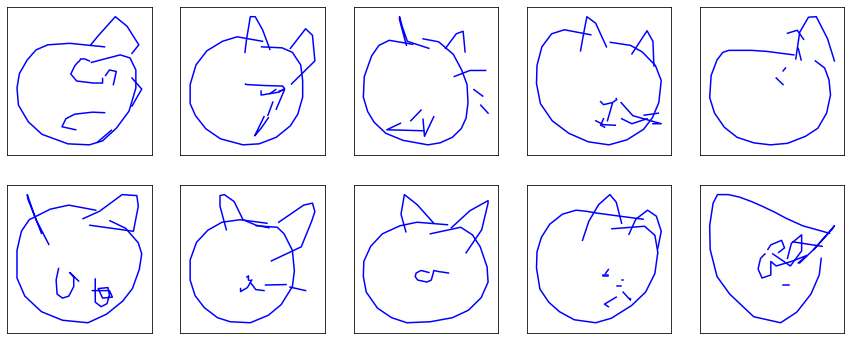

In [48]:
fig, axarr = get_canvas(2, 5)

start_of_stroke = extract_start_of_stroke(val_ds, n_points=1)

all_preds_strokes = []
for i, ax in enumerate(axarr.flatten()):
    pred_flat_strokes = generate(model, start_of_stroke, n_points=50)
    pred_flat_strokes = unstandarize_flat_strokes(pred_flat_strokes, val_means_stds)
    pred_strokes = inverse_transform_strokes(pred_flat_strokes)
    all_preds_strokes.append(pred_strokes)
    plot(pred_strokes, color='b', ax=ax)

In [52]:
%%capture
pred_anim = get_animation(all_preds_strokes[3])

In [53]:
# Generated drawing
HTML(pred_anim.to_html5_video())

In [54]:
pred_anim.save('generated.gif', dpi=80, writer='imagemagick')